In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

In [3]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 7):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    
    for tree_idx, tree in enumerate(model):
        
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        for vote_index in vote_indices:
            class_counts[tree.apply(X[vote_index].reshape(1, -1)).item(), y[vote_index]] += 1
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        where_empty = np.argwhere(class_probs.sum(axis = 1) == 0)
        for elem in where_empty:
            class_probs[elem] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy = np.mean(eval_entropies)
        
        return cond_entropy

In [4]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [5]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

In [6]:
# num_trials = 10
# n = 3000
# truth = 0.356

# ds = [1, 20, 40]
# kappas = [2, 3, 5, 7.5, 10]

# # Hyperparameter search.
# best_mse = 100000
# best_kappa = 0
# best_exp = 0
# best_var = 0
# for i, kappa in enumerate(kappas):
#     mse = 0
#     for j, d in enumerate(ds):
#         print("Trial %d out of %d in progress." % (len(kappas)*i + j, len(ds)*len(kappas)))
#         trials = np.zeros(num_trials)
#         for t in range(num_trials):
#             X, y = generate_data(n, d)
#             trials[t] = uf(X, y, kappa = kappa)
        
#         exp = np.mean(trials)
#         var = np.var(trials) / num_trials
#         mse += (exp - truth)**2 + var
        
#     if mse < best_mse:
#         best_mse = mse
#         best_kappa = kappa

# print("Best exp: ", best_exp)
# print("Best var: ", best_var)
# print("Best c: ", best_c)
# print("Best lambda: ", best_lambda)

## Compute True Conditional Entropy

In [7]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [8]:
def format_func(value, tick_number):
    epsilon = 10 ** (-5)
    if np.absolute(value) < epsilon:
        return "0"
    if np.absolute(value - 0.5) < epsilon:
        return "0.5"
    if np.absolute(value - 1) < epsilon:
        return "1"
    else:
        return ""

In [9]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos, panel):
        
    sample_sizes = np.array(pickle.load(open('sample_sizes_d_%d.pkl' % d, 'rb')))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes / 1000,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes / 1000, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
        
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_xlabel("Sample Size (thousands)")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("%s) Effect Size = %.1f" % (panel, mu))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [10]:
def plot_cond_entropy_by_mu(ax, d, n, algos, panel):
    
    mus = pickle.load(open('mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_ylim(ymin = -.05)
    ax.set_title("%s) n = %d" % (panel, n))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [11]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos, "A")
    plot_cond_entropy_by_mu(axes[0, 1], d1, n1, algos, "B")
    
    plot_cond_entropy_by_n(axes[1, 0], num_plotted_trials, d2, effect_size, algos, "C") 
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos, "D")
    
    axes[0,0].legend(loc = "upper left")
    
    fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    plt.tight_layout()
    plt.savefig("fig2.pdf", bbox_inches = "tight")
    plt.show()

In [12]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [13]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF1":
        c = 2
        lambda_ = 0.15
        d = X.shape[1]
        kappa = c * (d ** lambda_)
        return uf(X, y, kappa = kappa)
    elif label == "UF2":
        return uf(X, y, base = np.exp(1), kappa = 3)
    elif label == "UF3":
        return uf(X, y, base = np.exp(1), kappa = 8)
    elif label == "UF4":
        return uf(X, y, max_samples = .5, kappa = 5)
    elif label == "UF5":
        return uf(X, y, max_samples = .32, kappa = 5)
    else:
        raise ValueError("Unrecognized Label!")

In [14]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

## Run Experiments and Plot

In [15]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
effect_size = 1
d1 = 1
d2 = 20
n1 = 3000
n2 = 6000
num_trials = 20
num_plotted_trials = 10
sample_sizes_d1 = range(400, 2501, 300)
sample_sizes_d2 = range(500, 6001, 550)

# Fake params.
# mus = [i * 0.5 for i in range(1, 3)]
# effect_size = 1
# d1 = 1
# d2 = 3
# n1 = 100
# n2 = 110
# num_trials = 2
# num_plotted_trials = 2
# sample_sizes_d1 = range(100, 120, 10)
# sample_sizes_d2 = range(100, 130, 10)

# Algorithms.
algos = [
    {
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'UF1',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
    {
        'label': 'UF2',
        'title': 'Uncertainty Forest',
        'color': "orange",
    },
    {
        'label': 'UF3',
        'title': 'Uncertainty Forest',
        'color': "green",
    },
    {
        'label': 'UF4',
        'title': 'Uncertainty Forest',
        'color': "purple",
    },
    {
        'label': 'UF5',
        'title': 'Uncertainty Forest',
        'color': "gray",
    },
]

### Estimated H(Y | X) versus n, d = 1

In [16]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

array([[[0.11764149, 0.10835458, 0.09029804, ..., 0.13854273,
         0.14024222, 0.15468601],
        [0.10861659, 0.12309559, 0.12740649, ..., 0.12417303,
         0.1275547 , 0.12791645],
        [0.11755031, 0.1283575 , 0.12525713, ..., 0.12657348,
         0.13157959, 0.13237495],
        ...,
        [0.12301086, 0.12162581, 0.12938333, ..., 0.13778742,
         0.13034279, 0.13900534],
        [0.13614908, 0.13825117, 0.12745264, ..., 0.13646123,
         0.12802259, 0.13414532],
        [0.15235072, 0.12549035, 0.12130721, ..., 0.13179475,
         0.1446437 , 0.15814279]],

       [[0.40470003, 0.34059657, 0.30181172, ..., 0.4720793 ,
         0.36565915, 0.47469085],
        [0.37951795, 0.43189688, 0.34909042, ..., 0.42536418,
         0.41646941, 0.38986292],
        [0.38603863, 0.41881431, 0.43620507, ..., 0.41510636,
         0.42119602, 0.44907695],
        ...,
        [0.40044893, 0.44141549, 0.44184513, ..., 0.40889705,
         0.43324689, 0.38475661],
        [0.4

### Estimated H(Y | X) versus mu, d = 1

In [17]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

array([[[3.99671943e-01, 3.50545168e-01, 3.77063357e-01, ...,
         3.63947899e-01, 3.99343123e-01, 3.95793357e-01],
        [1.44321302e-01, 1.42525959e-01, 1.53040482e-01, ...,
         1.40062884e-01, 1.22883204e-01, 1.40826881e-01],
        [4.95348175e-02, 4.36247623e-02, 5.25879966e-02, ...,
         5.78494520e-02, 5.08158236e-02, 5.45403023e-02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.83121835e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[6.53626664e-01, 6.33674404e-01, 6.34911175e-01, ...,
         6.31701477e-01, 6.34692260e-01, 6.47052724e-01],
        [4.33083596e-01, 4.24500633e-01, 4.59538468e-01, ...,
         4.51369013e-01, 3.99891422e-01, 4.41278346e-01],
        [2.19598036e-01, 

### Estimated H(Y | X) versus n, d = 40

In [18]:
# Estimate conditional entropy vs n.
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

array([[[0.19443955, 0.18599567, 0.19099987, ..., 0.22685458,
         0.20177507, 0.18479943],
        [0.18334349, 0.17458561, 0.15534173, ..., 0.15824838,
         0.16951645, 0.15673386],
        [0.17314101, 0.16147046, 0.16752786, ..., 0.15820428,
         0.15981653, 0.1496884 ],
        ...,
        [0.14183754, 0.14792718, 0.13689047, ..., 0.14034761,
         0.13285433, 0.14763191],
        [0.14139894, 0.1448135 , 0.12656193, ..., 0.13827092,
         0.13304978, 0.14887709],
        [0.14449016, 0.13543843, 0.1509236 , ..., 0.13803407,
         0.14107694, 0.12704397]],

       [[0.38813047, 0.32559786, 0.38251267, ..., 0.40039683,
         0.40070874, 0.30072275],
        [0.37599553, 0.35836883, 0.34011897, ..., 0.33004086,
         0.39421991, 0.30558725],
        [0.38285094, 0.35827422, 0.33965026, ..., 0.3600321 ,
         0.38811012, 0.3514189 ],
        ...,
        [0.36336723, 0.39146861, 0.36019868, ..., 0.35358372,
         0.37842281, 0.37698669],
        [0.3

### Estimated H(Y | X) versus mu, d = 40

In [19]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

array([[[3.09468766e-01, 3.31791943e-01, 3.20844543e-01, ...,
         3.26251216e-01, 3.35141037e-01, 3.11044313e-01],
        [1.42197599e-01, 1.38137811e-01, 1.55779204e-01, ...,
         1.34185182e-01, 1.36298957e-01, 1.34099675e-01],
        [5.04358991e-02, 5.56338504e-02, 4.70332272e-02, ...,
         4.34024689e-02, 4.71837703e-02, 4.62563240e-02],
        ...,
        [5.88013625e-04, 7.77006345e-04, 7.77130612e-04, ...,
         7.22118673e-04, 7.03678136e-04, 6.58019415e-04],
        [6.81337947e-04, 7.25352938e-04, 6.82404875e-04, ...,
         7.25278616e-04, 6.92360313e-04, 6.52817336e-04],
        [6.02455974e-04, 6.52143807e-04, 5.93263640e-04, ...,
         7.22411940e-04, 5.92073177e-04, 8.45119611e-04]],

       [[5.87510009e-01, 5.98144295e-01, 5.89236933e-01, ...,
         6.02930767e-01, 6.02810445e-01, 5.81925885e-01],
        [3.73464678e-01, 3.50567578e-01, 3.82300873e-01, ...,
         3.67056057e-01, 3.57385374e-01, 3.64658909e-01],
        [1.67341195e-01, 

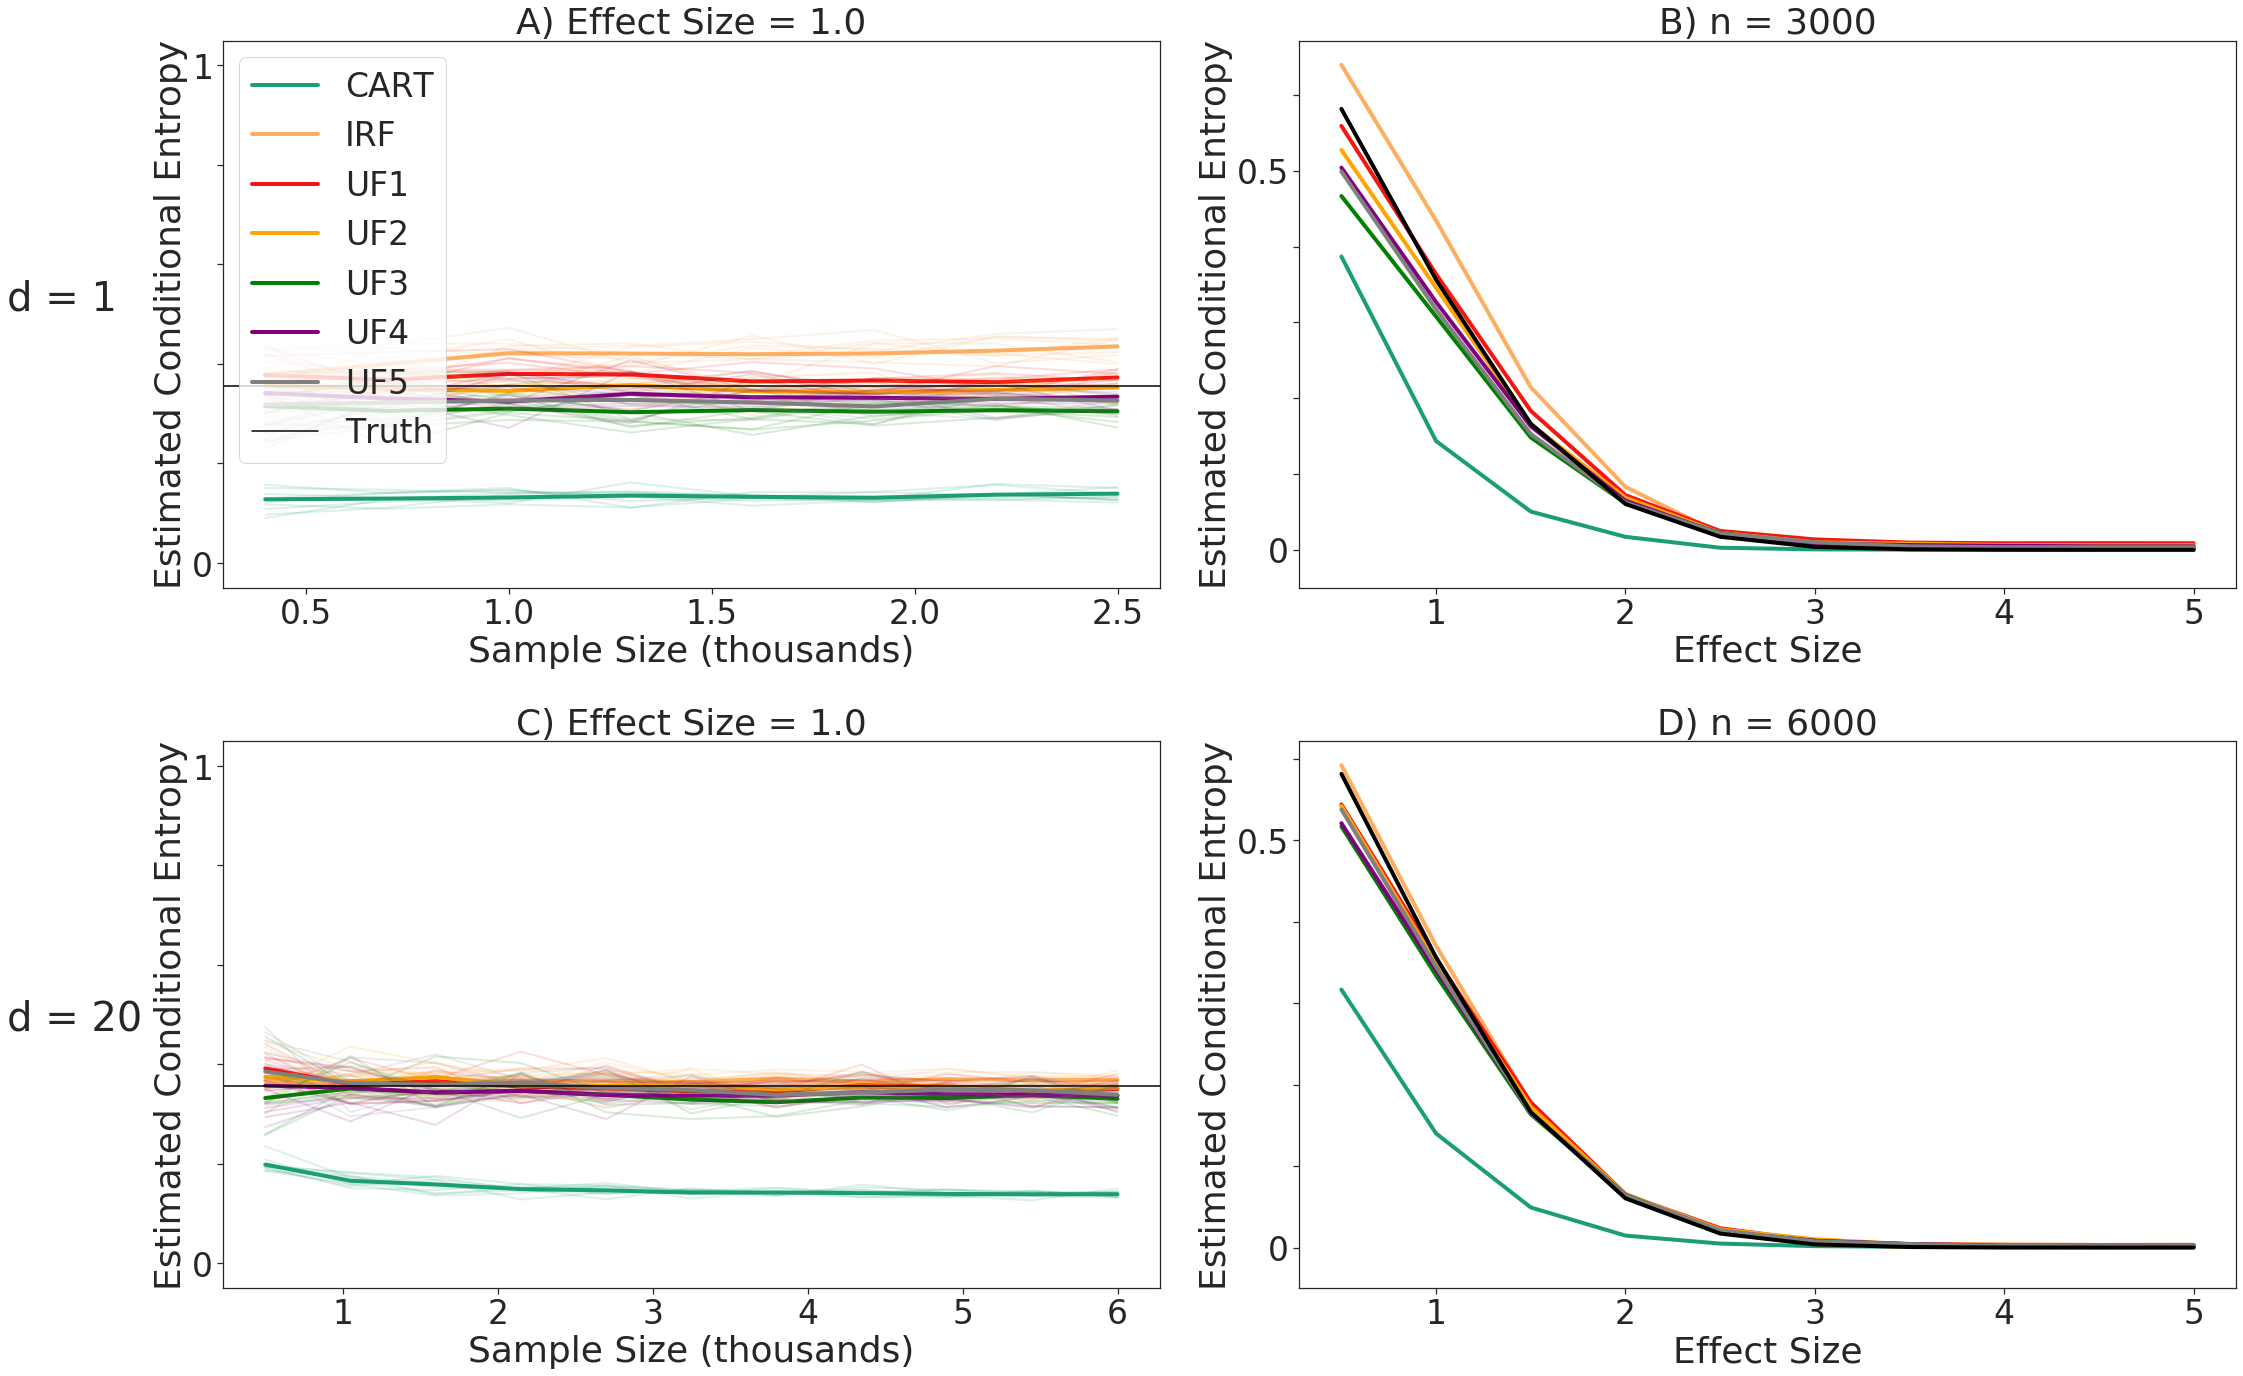

In [20]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)